# Market regime detection using Statistical and ML based approaches

## Introduction

Financial markets microstructure behaviour can vary over time, being affected by a wide range of external and internal factors. This can result in different market regimes or periods of continuous similar market conditions. Financial market participants aim to detect these market regimes and their shifts to handle potential risks and make better-informed investment decisions. 

Different approaches exist allowing the classification of market regimes. Many practitioners or researchers categorise markets as "boom" or "bust" markets, while others categorise them based on volatility, such as high, low, and mid-volatility regimes. Another approach is to classify market conditions into "risk on" or "risk off" states based on the investors' appetite. 

Identification of market regimes is an unsupervised process, and there is a wide range of techniques that can help to determine the current market state based on historical market data. These techniques include statistical approaches, such as vector autoregression models and hidden Markov models, as well as machine learning approaches, like clustering models e.g., k-means, agglomerative clustering, and gaussian mixture models. 

In the scope of this blueprint article, we aim to identify normal (growth) or crash (rapid decline) market states for S&P 500 using several statistical and ML models, including gaussian HMM, k-means clustering, and gaussian mixture models. Additionally, we build a simple investment strategy based on the identified market states and compare that with the base "Buy and Hold" strategy of the same asset throughout the analysis period. 


## Data Ingestion and Engineering

In this blueprint, we will be ingesting futures contracts on S&P 500 (ESc1). The reason we are employing the analysis and the strategy on futures instead of the index itself or an ETF, is that futures contracts are tradeable all day, whereas the ETFs are limited to exchange trading hours only. To acquire historical data on ESc1, we will use the Refinitiv Data (RD) Libraries API.

#### Install and import packages

To start, we first install and import the necessary packages. We use the Refinitiv Data platform API to retrieve the data. The code is built using Python 3.9. Other prerequisite packages are installed appropriately as shown below:

In [ ]:
#!pip install refinitiv-data 
#version 1.0.0

In [ ]:
#!pip install sklearn
#version 0.0.post1

In [ ]:
#!pip install hmmlearn
#version 0.2.8

In [ ]:
#!pip install plotly
#version 5.11.0

In [1]:
import refinitiv.data as rd
import numpy as np
# from sklearn.cluster import KMeans
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import warnings
import math

warnings.filterwarnings('ignore')

To use the API, we first need to authorize ourselves and open either a desktop or a platform session. In the scope of this article, we will be connected through a desktop session for which a Workspace app running in the background is required. More on the configuration of RD libraries can be found [here](https://github.com/Refinitiv-API-Samples/Example.DataLibrary.Python/tree/main/Configuration).

In [2]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x17e17b130 {name='workspace'}>

## Data Ingestion and Engineering

In this section, we ingest historical prices for ESc1 using RD Libraries from 01-01-1997 to 12-31-2022, then prepare for feeding to regime detection algorithms. 

Here is how we can request historical trade prices for the specified instrument and plot it.

In [3]:
trading_instrument = 'ESc1'
prices = rd.get_history(
                    universe = trading_instrument,
                    fields=['TRDPRC_1'],
                    start =  "1997-01-01",
                    end =  "2023-02-01",
)
prices = prices.loc[:,~prices.columns.duplicated()]
prices

TRDPRC_1       ESc1
Date               
1997-09-09   934.25
1997-09-10    917.5
1997-09-11   908.75
1997-09-12    924.5
1997-09-15    921.0
...             ...
2023-01-26  4067.75
2023-01-27   4084.0
2023-01-30  4039.75
2023-01-31  4085.75
2023-02-01   4142.5

[6398 rows x 1 columns]

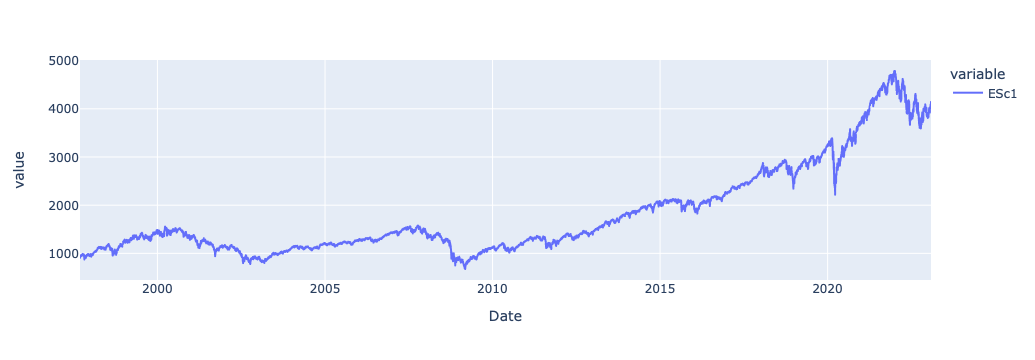

In [4]:
prices.columns.name = trading_instrument
px.line(prices['ESc1'])

After reviewing the price movement, we can determine a couple of market crashes within the analysed period. Of those, it is worth highlighting the 2007-2009 financial crisis, the COVID crash in February 2020, and the most recent recession period that started in early 2022. The goal of this regime detection prototype is to identify these and any other existing crash periods.

Before that, we prepare the data for regime detection model input. First, we derive a new feature from our data. the log return of the 7-day moving average of historical close prices. 

The advantage of using log returns instead of simple returns is that log returns are both symmetric and additive over time, making them a better measure when compared across different time periods. Additionally, log returns are normalised to the current price and are not affected by the level of the asset's price. Therefore, log returns also provide a better measure when comparing the performance of different instruments. 

The reason for calculating log returns on the moving average of the prices rather than the price itself is that a moving average helps to filter out random noise in the time series and smooths out short-term price changes. This allows concentrating on the long-term price movements instead. 


Below, we provide a function named *prepare_data_for_model_input*, which applies the abovementioned approach and returns a dataframe with close price, moving average price, and its log returns. Additionally, the function will return an array of log returns that will act as input to the regime detection models discussed in the next section. 


In [5]:
def prepare_data_for_model_input(prices, ma):
    '''
        Input:
        prices (df) - Dataframe of close prices
        ma (int) - legth of the moveing average
        
        Output:
        prices(df) - An enhanced prices dataframe, with moving averages and log return columns
        prices_array(nd.array) - an array of log returns
    '''
    
    intrument = prices.columns.name
    prices[f'{intrument}_ma'] = prices.rolling(ma).mean()
    prices[f'{intrument}_log_return'] = np.log(prices[f'{intrument}_ma']/prices[f'{intrument}_ma'].shift(1)).dropna()

    prices.dropna(inplace = True)
    prices_array = np.array([[q] for q in prices[f'{intrument}_log_return'].values])
    
    return prices, prices_array

Below, we call the function and present the resulting dataframe.

In [6]:
prices, prices_array = prepare_data_for_model_input(prices, 7)
prices

ESc1           ESc1      ESc1_ma  ESc1_log_return
Date                                             
1997-09-18   948.25   930.000000         0.002153
1997-09-19   960.25   936.107143         0.006545
1997-09-22    965.5   944.214286         0.008623
1997-09-23   961.75   949.535714         0.005620
1997-09-24    953.0   954.107143         0.004803
...             ...          ...              ...
2023-01-26  4067.75  4003.857143         0.002098
2023-01-27   4084.0  4023.607143         0.004921
2023-01-30  4039.75  4040.678571         0.004234
2023-01-31  4085.75  4054.642857         0.003450
2023-02-01   4142.5  4069.714286         0.003710

[6391 rows x 3 columns]

## Regime Detection

In this section, we briefly introduce several statistical and machine learning algorithms which we have used in this prototype to determine a market regime. Then we will use OOP to implement the regime detection process on ESc1. Finally, we will present the results of both in-sample and out-of-sample testing. 

There is a wide range of methodologies that can be applied in the context of market regime identification. Techniques range from anomaly detection statistical algorithms, such as Pruned Exact Linear Time (PELT), Dynamic programming and Binary segmentation search method, Sequentially Discounting Autoregression time series modeling, hidden Markov models. Unsupervised machine learning techniques include Agglomerative, k-means clustering, and Gaussian Mixture Models. In the scope of this article, in this article we will investigate the following methodologies: 

* Agglomerative Clustering: A hierarchical clustering method that recursively merges pairs of clusters of sample data; using linkage distances. This process is repeated until all data points belong in one cluster or a stopping criterion is met. More about this approach can be found [here.](https://www.sciencedirect.com/topics/computer-science/agglomerative-clustering)

* Gaussian Mixture Model (GMM): A GMM is a probabilistic model that describes a collection of multivariate Gaussian distributions. Each Gaussian component in a GMM represents a cluster in the data, and the parameters of the Gaussian distribution (mean and covariance) are estimated from the data. The GMM algorithm uses the Expectation-Maximization (EM) algorithm to find the optimal parameters of the Gaussian distributions that best fit the data. More about this approach can be found [here.](https://scikit-learn.org/stable/modules/mixture.html) 

* Hidden Markov Model (HMM): HMM is a sequential statistical model widely used in machine learning (i.e., speech recognition, natural language processing, bioinformatics, and finance). HMM models rely on state graphs defined by initial state probabilities, state transition probabilities, and observation emission probabilities. Transition probabilities of an HMM govern the state of the system and depending on the observations,  its transition to a new state . This is the expected behaviour when using the model for analysing market regimes. The overall goal of the HMM is to estimate the underlying hidden states given the observed data. This is achieved through algorithms such as Viterbi or Baum-Welch. More about the HMM can be found [here.](https://www.quantstart.com/articles/hidden-markov-models-an-introduction/) 

#### Modeling and in-sample testing

During this phase, we define a Python object named RegimeDetection encapsulating functions to determine market regimes by utilising Agglomerative clustering, GMM, and HMM models, respectively. Additionally, we define the initialise_model function, which acts as a constructor of the respective models as attributes. This allows us to instantiate the models by providing  execution parameters as input rather than hard coding in the object. 

Regarding regime detection functions, these accept input data (df) and params(dict) as input and return the respective model. 

In [7]:
class RegimeDetection:

    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
    
    def get_regimes_clustering(self, params):
        clustering =  self.initialise_model(AgglomerativeClustering(), params)
        return clustering
    
    def get_regimes_gmm(self, input_data, params):
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm
        
    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model
            

Furthermore, we define a separate function to plot the returned hidden states along with the close prices. 

In [8]:
def plot_hidden_states(hidden_states, prices_df):
    
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    
    '''
    
    colors = ['blue', 'green']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
 
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i,":", len(prices_df.index[mask]))
        
        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df[f"{prices_df.columns.name}"][mask],
                    mode='markers',  name='Hidden State ' + str(i), marker=dict(size=4,color=colors[i])))
        
    fig.update_layout(height=400, width=900, legend=dict(
            yanchor="top", y=0.99, xanchor="left",x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()


Now, we are ready to initialize the RegimeDetection object and review in sample results for each model. 

In [9]:
regime_detection = RegimeDetection()

After initialising the object, we will first use Agglomerative clustering to identify ESc1 market regimes. We provide the list of parameters we would like our model to be initialised with. Particularly, cluster the data points in 2 clusters using the manhattan distance with complete linkage. Afterwards, we initialize the model and plot the predicted hidden states in a graph. The parameters are selected based on the best outcome from several experiments.

Number of observations for State  0 : 6335
Number of observations for State  1 : 56


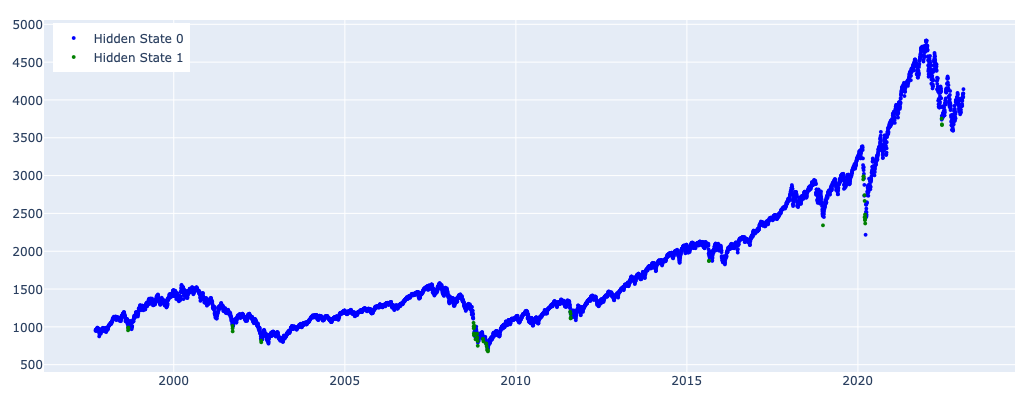

In [10]:
params = {'n_clusters': 2, 'linkage': 'complete',  'affinity': 'manhattan', 'metric': 'manhattan', 'random_state':100}
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array)

plot_hidden_states(np.array(clustering_states), prices[[f'{trading_instrument}']])

From the graph above, we can see that agglomerative clustering was able to detect 56 hidden 1 states, which corresponds to some of the crashes throughout the analysed period. Specifically, it could highlight the financial crisis and the COVID shock. However, it is worth highlighting that the detection is lagging, and the model detects only observations during the end of the crash period. Moreover, if we zoom into specific periods during the identified crash incidents, we see that hidden 1 states  are sparse as several hidden 0 states are identified during the same period. These challenges would limit the usage of hidden state predictions via our agglomerative clustering model in an investment strategy. 

Let us now utilise the GMM model and observe if it identifies market regimes any better. We initialize the model with custom parameters, then plot the predicted hidden states in a graph. The parameters are selected based on the best outcome from several experiments. 

Number of observations for State  0 : 5887
Number of observations for State  1 : 504


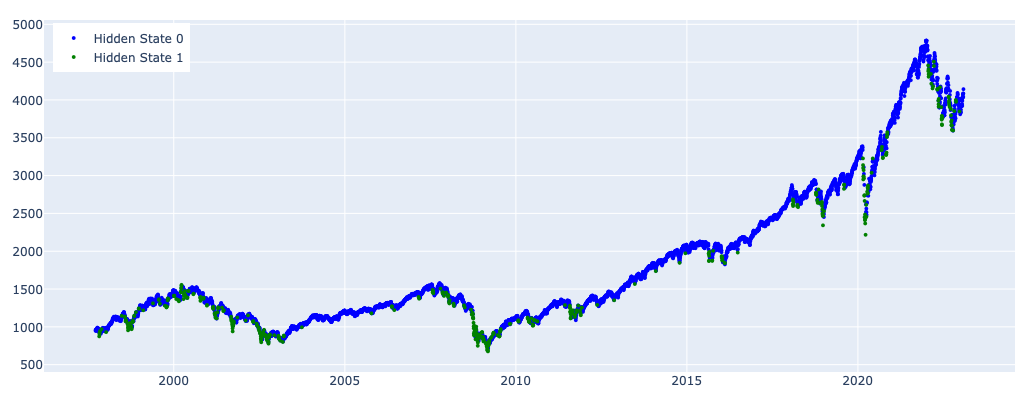

In [11]:
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}

gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(np.array(gmm_states), prices[[f'{trading_instrument}']])

The graph above presents the distribution of hidden states predicted by the GMM. The model classified 504 observations as hidden state 1, which we attributed to the crash period. Compared with the Agglomerative clustering approach, we see that GMM could detect market regimes much better and with smaller lags. Although better than the Agglomerative clustering results, hidden 1 states are also quite sparse here. It should also be mentioned that both results come from in-sample testing, and as expected, out-of-sample testing may lead to worse results. 

Finally, let us now detect market regimes using HMM and compare the results with the two other approaches. We initialise the model with custom parameters, then plot the predicted hidden states in a graph. The parameters are selected based on the best outcome from several experiments. 

Number of observations for State  0 : 891
Number of observations for State  1 : 5500


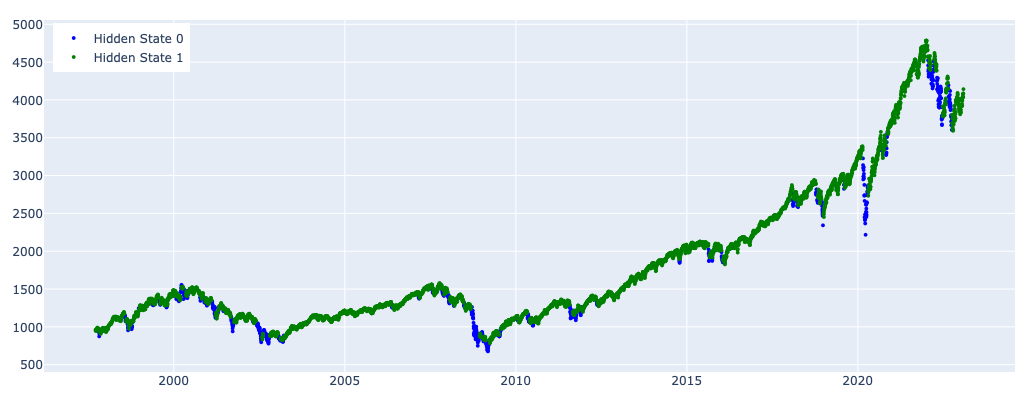

In [12]:
params = {'n_components':2, 'covariance_type':"full", 'random_state':100}

hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
hmm_states = hmm_model.predict(prices_array)
plot_hidden_states(np.array(hmm_states), prices[[f'{trading_instrument}']])

According to the graph presenting the state distribution predicted by HMM, we observe better segregation at least compared to the Agglomerative clustering approach. Although overall the graphs are similar to the GMM graphs, the states continuity is much steadier, which is important for an efficient investment strategy. The HMM could identify both financial and COVID crashes, as well as (with some lags) the volatile period starting after January 2022.

Again, we should note that all the analyses in this section so far have been done in-sample affecting the robustness of the results. Later in the article, we employ feed-forward training with out-of-sample testing and build our investment strategy on those results.

#### Feed-forward training and out of sample testing

Considering that in-sample testing results from agglomerative clustering were insufficient to base an investment strategy on, we implement feed-forward training and out-of-sample testing for the GMM and HMM models. To implement the feed-forward training, we define a function that: 

1. Trains the HMM or GMM model on an initial training dataset 
2. Predicts the state of the next observation 
3. Retrains the model after the specified training step - the number of observations after which we retrain.

Below we implement the function for feed-forward training. The function accepts, as input variables, the model, parameters, close prices, splitting index, and retraining step size as input and return state predictions. 

In [17]:
def feed_forward_training(model, params, prices, split_index, retrain_step):
    '''
    Input:
    model (<class 'method'>) - either gmm (Gaussian Mixture Models) or hmm (Hidden Markov Model)
    params (dict) - dictionary of parameters for a model
    prices (df) - Dataframe of close prices
    split_index (str) - index to split initial traing dataset and out of sample testing set
    retrain_step (int) - number of observations after which we retrain the model
    
    Output:
    states_pred (numpy.ndarray) - array of predicted hidden states
    '''
    # train/test split and initial model training
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]
    rd_model = model(init_train_data, params)
    
    # predict the state of the next observation
    states_pred = []
    for i in range(math.ceil(len(test_data))):
        split_index += 1
        preds = rd_model.predict(prices[:split_index]).tolist()
        states_pred.append(preds[-1])
        
        # retrain the existing model
        if i % retrain_step == 0:
            rd_model = model(prices[:split_index], params)
            
    return  states_pred

Before running the function, let's first specify the model, parameters, and the split index to divide the dataset into an initial training set and out of sample testing set. 

It should be noted that in the scope of this article, we used the same parameters we had during the in-sample training. Therefore, there is room for parameter optimisation which can be implemented by splitting the data into train, validation and test sets and executing a grid search technique. First, let us investigate GMM results by splitting the date up to 2006-01-01 (initial train set) and after (test set).

First, let's investigate results for GMM by splitting the date up to 2006-01-01 (initial train set) and afterward (test set). 

In [18]:
model_gmm =  regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100, 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]

After defining the params, model, and split index, we run the feed-forward training model with retraining after every 20 observations and plot the predicted hidden states using the GMM.

Number of observations for State  0 : 2808
Number of observations for State  1 : 1496


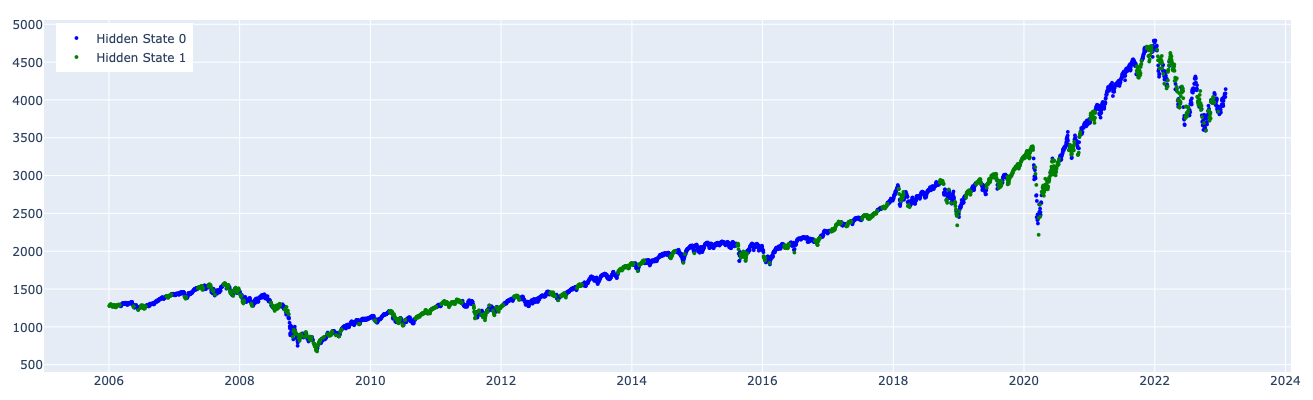

In [19]:
states_pred_gmm = feed_forward_training(model_gmm, params, prices_array, split_index, 20)
plot_hidden_states(np.array(states_pred_gmm), prices[[f'{trading_instrument}']][split_index:])

According to the graph above, as expected, out-of-sample testing results are much worse compared to the in-sample results for the GMM. Particularly, the model shows moderate predictive steadiness during crash periods. Although the model could mostly identify the crash periods, it falsely highlighted many upward market movements as crashes , which makes it less useful for building an investment strategy. 

Now, let us investigate the results for the HMM using the same split date and retraining step size. Again, the HMM parameters are used the same as for the in-sample testing. Below we define the parameters, run the feed-forward training function, and plot the predicted hidden states.

In [20]:
model_hmm =  regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type': 'full', 'random_state':100}

Number of observations for State  0 : 343
Number of observations for State  1 : 3961


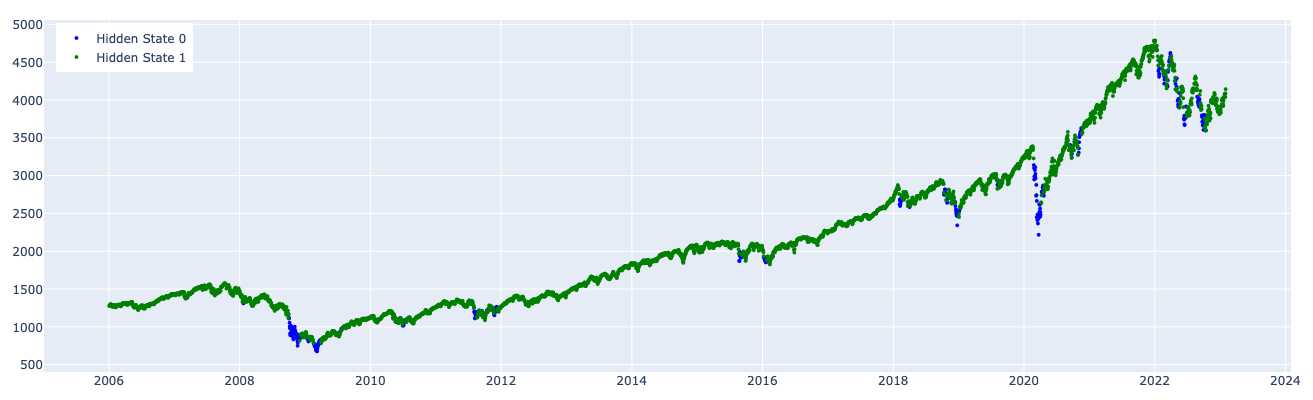

In [21]:
states_pred_hmm = feed_forward_training(model_hmm, params, prices_array, split_index, 20)
plot_hidden_states(np.array(states_pred_hmm), prices[[f'{trading_instrument}']][split_index:])

The results are much better for the HMM, as we can see how it highlighted the crash periods , particularly the financial and covid pandemic period crashes. The model is showing lower stability when predicting the volatile period that started after 2022. This might be because of a change in the overall volatility regime, as during the abovementioned two crashes, there were steep and long-term dips; however, the crash after 2022 has many short-term trends and high volatility periods. This challenge can be addressed by tuning model parameters, changing the features  (e.g., taking different periods moving averages) and/or changing the retraining period. None of those is implemented in the scope of this article and can be a subject to further research and analysis.

Furthermore, in this blueprint, we build a simple investment strategy that makes long, and short transactions based on the predicted outputs from the HMM.

## Implementing an Investment Strategy

In this section, we implement a simple investment strategy based on the predicted hidden states, which is generating: 

* A long signal when the market is expected to stay  in a normal state 
* A short signal when the market is in a crash or high volatility state

In  this article, we have not built an end-to-end investment strategy considering transaction fees, slippage costs, margin calls, etc.; instead, we simply accumulate daily profit/loss based on the price change and our active 
position of the day. We then compare our strategy’s profit and loss results with a base Buy and Hold strategy. 

As a first step, let us merge the daily close prices with the predicted states for that day.

In [22]:
prices_with_states = pd.DataFrame(prices[split_index:][f'{trading_instrument}'])
prices_with_states['State'] = states_pred_hmm
prices_with_states.head()

ESc1  State
Date                      
2006-01-03  1274.75      1
2006-01-04   1280.5      1
2006-01-05  1281.25      1
2006-01-06   1292.0      1
2006-01-09  1294.75      1

Next, let's calculate the daily log returns of close prices.

In [23]:
prices_with_states['P&L_daily'] = np.log(prices_with_states['ESc1'] / prices_with_states['ESc1'].shift(1)).dropna()
prices_with_states.head()

ESc1  State  P&L_daily
Date                                 
2006-01-03  1274.75      1       <NA>
2006-01-04   1280.5      1   0.004501
2006-01-05  1281.25      1   0.000586
2006-01-06   1292.0      1   0.008355
2006-01-09  1294.75      1   0.002126

Because we predict the state for a day after the market closes, and to avoid look ahead bias we will open/close a position with that day's close price but accumulate the next day's profit or loss. For that purpose, we shift the states by one day.

In [24]:
prices_with_states['State'] = prices_with_states['State'].shift(1)
prices_with_states.dropna(inplace = True)

According to the graph showing the state distribution predicted by the HMM, the normal state is labeled as State 1 and the high Volatility state as State 0. Therefore, we will go long when the market is in State 1 and short when in State 0. We create a new column for the position, where the position is 1 when state 1, and -1, otherwise.

In [25]:
prices_with_states['Position'] = np.where(prices_with_states['State'] == 1,1,-1)
prices_with_states.head()

ESc1  State  P&L_daily  Position
Date                                           
2006-01-04   1280.5    1.0   0.004501         1
2006-01-05  1281.25    1.0   0.000586         1
2006-01-06   1292.0    1.0   0.008355         1
2006-01-09  1294.75    1.0   0.002126         1
2006-01-10  1296.25    1.0   0.001158         1

We can now calculate the daily profit or loss based on our position and accumulate it over the period. Below, we calculate the Daily Strategy Outcome by multiplying our position (1 if long, -1 if short) by the daily P&L. We then calculate the cumulative sums of daily P&Ls to compute the cumulative outcome of the Buy and Hold Strategy. We also accumulate daily outcomes of our positions to calculate the cumulative outcome of the HMM-based strategy.

In [26]:
prices_with_states['Daily_Outcome_hmm'] = prices_with_states['Position'] * prices_with_states['P&L_daily']
prices_with_states['Cumulative_Outcome_BaH'] = prices_with_states['P&L_daily'].cumsum()
prices_with_states['Cumulative_Outcome_hmm'] = prices_with_states['Daily_Outcome_hmm'].cumsum()
prices_with_states

ESc1  State  P&L_daily  Position  Daily_Outcome_hmm  \
Date                                                                 
2006-01-04   1280.5    1.0   0.004501         1           0.004501   
2006-01-05  1281.25    1.0   0.000586         1           0.000586   
2006-01-06   1292.0    1.0   0.008355         1           0.008355   
2006-01-09  1294.75    1.0   0.002126         1           0.002126   
2006-01-10  1296.25    1.0   0.001158         1           0.001158   
...             ...    ...        ...       ...                ...   
2023-01-26  4067.75    1.0   0.009448         1           0.009448   
2023-01-27   4084.0    1.0   0.003987         1           0.003987   
2023-01-30  4039.75    1.0  -0.010894         1          -0.010894   
2023-01-31  4085.75    1.0   0.011323         1           0.011323   
2023-02-01   4142.5    1.0   0.013794         1           0.013794   

           Cumulative_Outcome_BaH Cumulative_Outcome_hmm  
Date                                                      
2006-01-04               0.004501               0.004501  
2006-01-05               0.005086               0.005086  
2006-01-06               0.013441               0.013441  
2006-01-09               0.015568               0.015568  
2006-01-10               0.016725               0.016725  
...                           ...                    ...  
2023-01-26                1.16034               1.288889  
2023-01-27               1.164327               1.292876  
2023-01-30               1.153433               1.281982  
2023-01-31               1.164755               1.293304  
2023-02-01               1.178549               1.307098  

[4303 rows x 7 columns]

Finally, we plot the cumulative outcomes from both strategies to compare the results. 

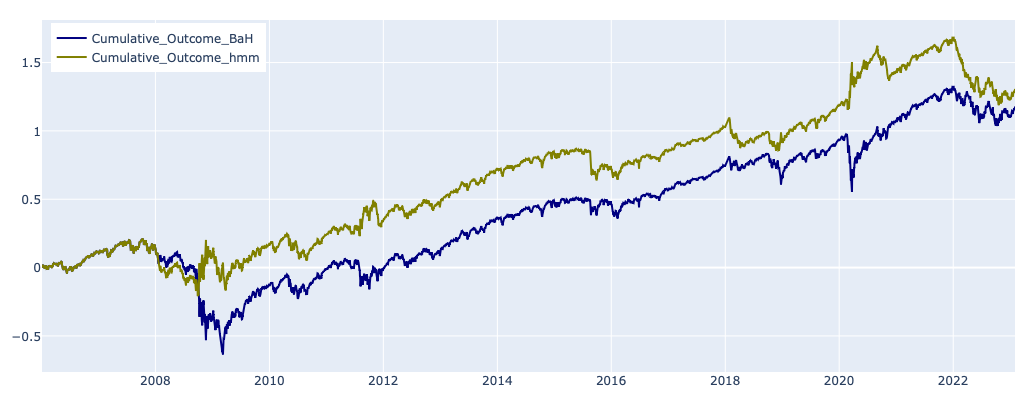

In [28]:
fig = go.Figure()

fig.add_trace(go.Line(x=prices_with_states.index, y=prices_with_states["Cumulative_Outcome_BaH"], 
                      name = 'Cumulative_Outcome_BaH', line_color = 'navy'))

fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_hmm'], 
                      name = 'Cumulative_Outcome_hmm', line_color = 'olive'))

fig.update_layout(height=400, width=900, legend=dict(
    yanchor="top", y=0.99, xanchor="left",x=0.01), 
    margin=dict(l=20, r=20, t=20, b=20))

fig.show()

According to the graph, the HMM-based strategy outperforms the base Buy and Hold strategy. The strategies had similar behaviour for about two years as there were no changes in the market regime, and the HMM strategy matched the Buy and Hold one. However, during the financial crisis, as the market regime shifted, the HMM-based strategy started opening short sell positions, resulting in profits, whereas the base strategy incurred losses. Throughout the analysed period, both strategies continued to accrue profits until the COVID crash. During that period, the HMM-based strategy not only avoided the crash but also accumulated some profit by opening a short-sell position, which continued to generate profits until the beginning of 2022. However, after that, the profit from the HMM-based strategy decreased due to lagged regime shift identification and states prediction scarcity. Despite this drop, the HMM strategy is still outperforming the base strategy as of January 2023. As mentioned previously, the lagged behavior may be addressed by introducing an adaptive retraining mechanism (e.g., adapt retraining period, change moving averages periodicity as a model input). To address sparsity, a regime shift confirmation can be introduced, which opens a lot of room for experimentation that was beyond the scope of this current article and could be the subject of future work.

## Conclusion

In this article, we presented several statistical and machine learning models for detecting market regimes and applied them to S&P 500 futures. We conducted both in-sample and out-of-sample training and found that the Hidden Markov Model provided the best identification of market regime shifts. We also built a simple investment strategy based on the predicted states, which outperformed a buy-and-hold strategy during the period 2006-2023. It is important to note that the strategy did not consider factors such as transaction and slippage costs, which could affect the results. The article's main goal was not to provide a model for real-world trading but rather to demonstrate market regime detection approaches that could be combined with more advanced investment strategies.